## Importing Libraries
This section imports all necessary libraries for file handling, image processing, model creation, training, and evaluation.

In [1]:
# File Handling, Numerical Operations, Image Processing, Visualisation, Deep Learning, and Delete Folder
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

# Building and Evaluating the CNN Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Data Splitting, Class Balancing, and Performance Evaluation
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

2025-05-15 03:32:50.719960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747279970.915539      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747279970.976501      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the Dataset
Function to load and label MRI images from folders, and convert them to the desired shape.

In [2]:
def load_mri(folder, label, target_size):
    images = []
    labels = []

    for dirname, _, filenames in os.walk(folder):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            mri_img = cv2.imread(path)  # Read image
            if mri_img is not None:
                mri_img = cv2.resize(mri_img, target_size)  # Resize image
                images.append(mri_img)
                labels.append(label)

    return images, labels

## Preprocessing Images
Resize all MRI images to a standard shape (128x128) and normalize pixel values.

In [3]:
target_size = (128, 128)

In [4]:
positive, positive_labels = load_mri('/kaggle/input/brain-tumor-dataset/Brain_Tumor_Dataset/Positive', 1, target_size)
negative, negative_labels = load_mri('/kaggle/input/brain-tumor-dataset/Brain_Tumor_Dataset/Negative', 0, target_size)

## Dataset Preparation
Combine positive and negative samples, normalize pixel values, and split into training and test sets.

In [5]:
X = np.array(positive + negative) / 255.0   # Divide by 255 to Normalise Pixel Values 0 to 1
y = np.array(positive_labels + negative_labels) # Combine Labels

In [6]:
train_mri, test_mri, train_labels, test_labels = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Handling Class Imbalance
Compute class weights to address imbalanced dataset during training.

In [7]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict) # Print Class Weights

Class Weights: {0: 1.31625, 1: 0.8062787136294027}


## Building the CNN Model
Create a Convolutional Neural Network (CNN) to classify MRI images.

In [8]:
aug = ImageDataGenerator(rotation_range=15, zoom_range=0.1, horizontal_flip=True)

In [9]:
brain_tumour_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), # 1. Conv Layer
    MaxPooling2D(2, 2), # 1. Pooling Layer
    Conv2D(64, (3, 3), activation='relu'), # 2. Conv Layer
    MaxPooling2D(2, 2), # 2. Pooling Layer
    Flatten(), # Output to 1D
    Dropout(0.5), # Prevent Overfitting
    Dense(128, activation='relu'), # Fully Connected Layer
    Dense(1, activation='sigmoid') # Output Layer for Binary Classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747280015.205633      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Training the Model
Train the CNN model using the training dataset with class weights and validation.

In [10]:
brain_tumour_cnn.compile(
    optimizer='adam', # Optimiser
    loss='binary_crossentropy', # Loss Function
    metrics=['accuracy', AUC(), Precision(), Recall()] # Evaluate
)

In [11]:
brain_tumour_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

## Evaluating the Model
Evaluate the model’s performance using accuracy and classification report.

In [12]:
save_best = ModelCheckpoint(
    'model/brain_cnn.keras',
    monitor='val_accuracy', # Save Best by Validation Accuracy
    save_best_only=True, # Save Only the Best Model
    mode='max',
    verbose=1
)

In [13]:
stop_training = EarlyStopping(
    monitor='val_accuracy',
    patience=5, # Wait 5 Epochs Before Early Stopping
    restore_best_weights=True, # Restore Weights from Best Epoch
    verbose=1
)

In [14]:
start_time = time.time()
hist = brain_tumour_cnn.fit(
    aug.flow(train_mri, train_labels, batch_size=32), # Use Augmented Images
    epochs=50,
    validation_data=(test_mri, test_labels),
    callbacks=[save_best, stop_training],
    class_weight=class_weight_dict # Apply Balanced Class Weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1747280019.903196      59 service.cc:148] XLA service 0x7d0c1400bfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747280019.903883      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747280020.238204      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/132 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.4792 - auc: 0.7258 - loss: 0.6403 - precision: 0.5556 - recall: 0.2696         

I0000 00:00:1747280023.236971      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7868 - auc: 0.8749 - loss: 0.4323 - precision: 0.8784 - recall: 0.7609
Epoch 1: val_accuracy improved from -inf to 0.93548, saving model to model/brain_cnn.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.7875 - auc: 0.8754 - loss: 0.4313 - precision: 0.8788 - recall: 0.7617 - val_accuracy: 0.9355 - val_auc: 0.9860 - val_loss: 0.1987 - val_precision: 0.9900 - val_recall: 0.9052
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9335 - auc: 0.9790 - loss: 0.1818 - precision: 0.9646 - recall: 0.9239
Epoch 2: val_accuracy improved from 0.93548 to 0.94118, saving model to model/brain_cnn.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.9335 - auc: 0.9790 - loss: 0.1817 - precision: 0.9646 - recall: 0.9239 - val_accuracy: 0.9412 - val_auc: 0.9885 - val_loss: 0.1924 - val_precision: 0.9966 - val_recall: 0.9083
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9502 - auc: 

## Visualising Predictions
Visualize model predictions on test data to interpret results.

In [15]:
end_time = time.time()
elapsed_time = end_time - start_time
train_mins = int(elapsed_time // 60)
train_secs = int(elapsed_time % 60)

In [16]:
def training_stats(hist, test_labels, y_pred, y_pred_prob):
    stats = ['accuracy', 'loss', 'precision', 'recall', 'auc'] # Metrics
    for stat in stats:
        if stat in hist.history:
            plt.figure()
            plt.plot(hist.history[stat], label=f"Train {stat.capitalize()}")
            plt.plot(hist.history[f"val_{stat}"], label=f"Validation {stat.capitalize()}")
            plt.title(f"Training and Validation {stat.capitalize()}")
            plt.xlabel("Epoch")
            plt.ylabel(stat.capitalize())
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show() # Display All Plots

    # Confusion Matrix
    cm = confusion_matrix(test_labels, y_pred) # Create Confusion Matrix
    plt.imshow(cm, cmap='Blues') # Visualise Confusion Matrix
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0,1], ['No Tumour', 'Tumour'])
    plt.yticks([0,1], ['No Tumour', 'Tumour'])
    plt.colorbar()
    plt.tight_layout()
    plt.show() # Display Confusion Matrix

    # ROC Curve
    fpr, tpr, _ = roc_curve(test_labels, y_pred_prob) # Calculate FP and TP Rates
    auc_val = roc_auc_score(test_labels, y_pred_prob) # Calculates AUC
    plt.plot(fpr, tpr, label=f"Model (AUC = {auc_val:.2f})")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show() # Display ROC Curve

In [17]:
tumour_model = load_model('model/brain_cnn.keras')

In [18]:
# Make Predictions on 20% Test Data
y_pred_prob = tumour_model.predict(test_mri)  # Probability Score
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Binary Class Pred

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [19]:
# Compute Evaluation Statistics
report = classification_report(test_labels, y_pred)
f1_score_val = f1_score(test_labels, y_pred)
auc_val = roc_auc_score(test_labels, y_pred_prob)
accuracy = accuracy_score(test_labels, y_pred)
conf_matrix = confusion_matrix(test_labels, y_pred)
val_acc = max(hist.history['val_accuracy'])
error_analysis = [i for i in range(len(test_labels)) if test_labels[i] != y_pred[i]]
misclassified_val = len(error_analysis) # Number of Misclassified Images
total_samples = len(test_labels)

In [20]:
print("Report:\n", report)
print("Stats:")
print(f"Final Accuracy         : {accuracy:.4f}")
print(f"F1 Score               : {f1_score_val:.4f}")
print(f"AUC Score              : {auc_val:.4f}")
print(f"Validation Accuracy    : {val_acc:.4f}")
print(f"Training Time          : {train_mins} minutes {train_secs} seconds")
print(f"Misclassified Images   : {misclassified_val} out of {total_samples}\n")
print(f"Confusion Matrix:\n{conf_matrix}")

Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.99      0.99       654

    accuracy                           0.99      1054
   macro avg       0.99      0.99      0.99      1054
weighted avg       0.99      0.99      0.99      1054

Stats:
Final Accuracy         : 0.9905
F1 Score               : 0.9923
AUC Score              : 0.9990
Validation Accuracy    : 0.9905
Training Time          : 5 minutes 58 seconds
Misclassified Images   : 10 out of 1054

Confusion Matrix:
[[399   1]
 [  9 645]]


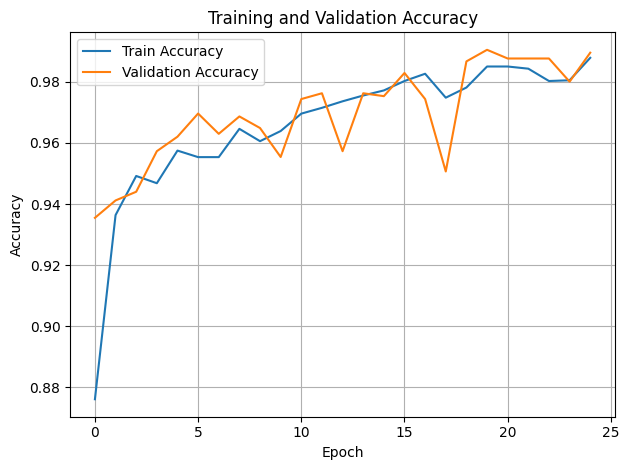

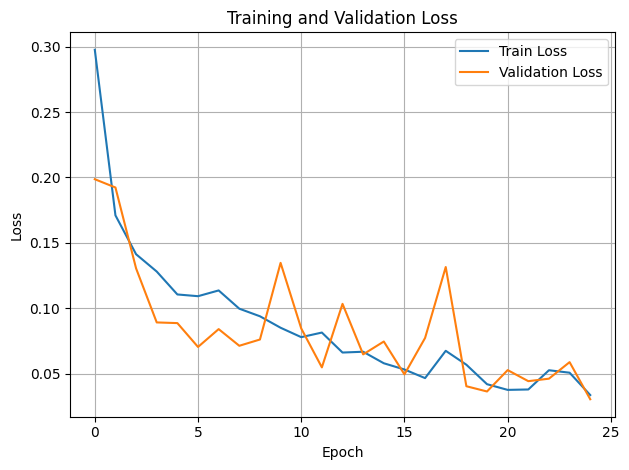

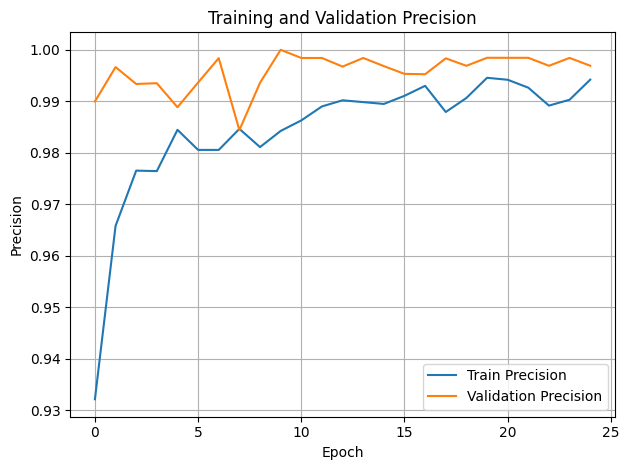

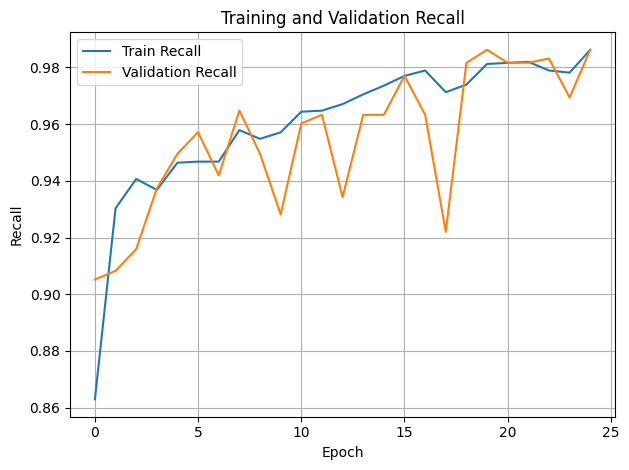

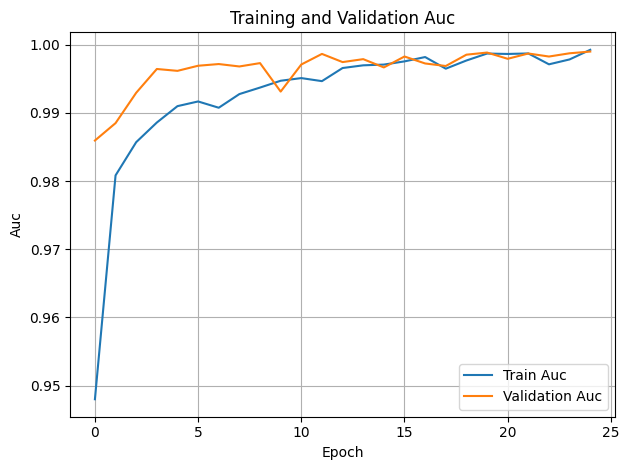

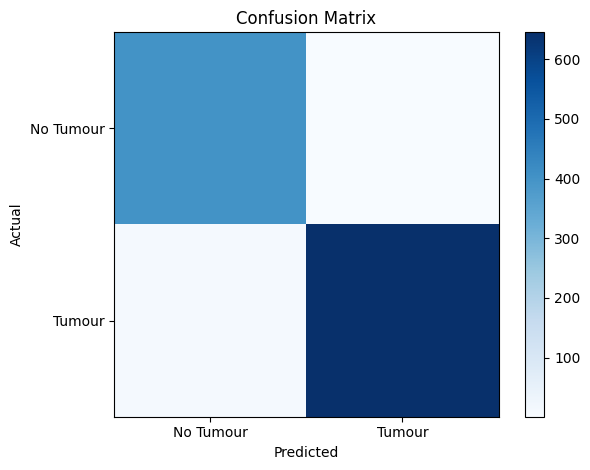

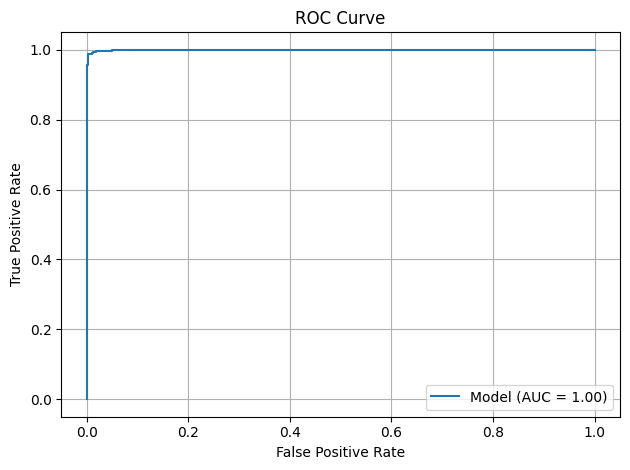

In [21]:
training_stats(hist, test_labels, y_pred, y_pred_prob)